# 문제
The following describes MobileNet architecture. Implement the model using TensorFlow Keras library. Train the model with Adam optimizer using CIFAR-10 dataset. Report the final test accuracy. Use **tf.keras.layers.DepthwiseConv2D** for the depthwise convolution. Use Google Colaboratory as your development environment. Turn your .ipynb file in here.

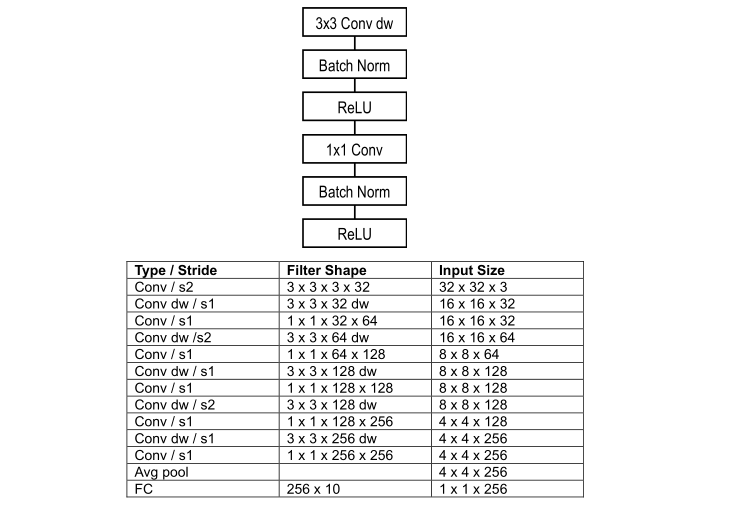

## 1. settings

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model

## 2. CIFAR-10 데이터 불러오기 & EDA

- 데이터 불러오기

In [ ]:
from keras.datasets import cifar10 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

- 데이터 잘 불러 왔는지 확인
  - sample 이미지 출력

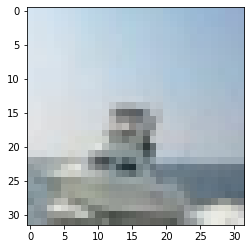

In [ ]:
#100번째 -> 배 사진
plt.imshow(x_train[100])

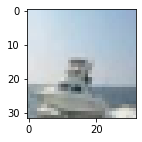

In [ ]:
#100번째 -> 배 사진
plt.figure(figsize = (2, 2))
plt.imshow(x_train[100])

- 데이터 shape

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

- 데이터 갯수, label 갯수
  - train data: 50000
  - test data: 10000
  - label: 10

In [ ]:
#label의 갯수 확인하기 위해서
#label은 0~9까지 10개!
y_train[:30]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3],
       [4],
       [7],
       [7],
       [2],
       [9],
       [9],
       [9],
       [3],
       [2],
       [6],
       [4],
       [3],
       [6],
       [6],
       [2],
       [6],
       [3],
       [5],
       [4],
       [0]], dtype=uint8)

## 3. 데이터 전처리
- 데이터 정규화 (Standardization)
- reshape

In [ ]:
print ("mean before normalization:", np.mean(x_train)) 
print ("std before normalization:", np.std(x_train))

mean=[0,0,0]
std=[0,0,0]
newx_train = np.ones(x_train.shape)
newx_test = np.ones(x_test.shape)
#train set에 있는 데이터로만 평균과 표준편차를 구하기
for i in range(3):
    mean[i] = np.mean(x_train[:,:,:,i])
    std[i] = np.std(x_train[:,:,:,i])

#train과 test셋 모두 정규화    
for i in range(3):
    newx_train[:,:,:,i] = x_train[:,:,:,i] - mean[i]
    newx_train[:,:,:,i] = newx_train[:,:,:,i] / std[i]
    newx_test[:,:,:,i] = x_test[:,:,:,i] - mean[i]
    newx_test[:,:,:,i] = newx_test[:,:,:,i] / std[i]
        
x_train = newx_train
x_test = newx_test

print ("mean after normalization:", np.mean(x_train))
print ("std after normalization:", np.std(x_train))
print(x_train.max())

mean before normalization: 120.70756512369792
std before normalization: 64.1500758911213
mean after normalization: 4.91799193961621e-17
std after normalization: 0.9999999999999996
2.126789409516928


In [ ]:
# y reshape
y_train = y_train.reshape(-1,)

## 4. 모델 만들기

In [ ]:
n_row = x_train.shape[1] #32
n_col = x_train.shape[2] #32
n_chan = x_train.shape[3] #3
n_class = 10

In [ ]:
# Conv 함수
def Conv(x, _filter, _stride):
  x = Conv2D(filters=_filter, kernel_size=[1, 1], strides=_stride, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.1)(x) #overfitting 방지하기 위해 dropout 추가

  return x

# Conv_dw 함수
def Conv_dw(x, _stride):
  x = DepthwiseConv2D(kernel_size=[3, 3], strides=_stride, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.1)(x) #overfitting 방지하기 위해 dropout 추가
  return x


In [ ]:
n_row = x_train.shape[1] #32
n_col = x_train.shape[2] #32
n_chan = x_train.shape[3] #3
n_class = 10

- 모델 만들기

In [ ]:
#input
x_input = Input(batch_shape = (None, n_row, n_col, n_chan))

#Conv/s2
x = Conv(x_input, 32, 2)

#Conv dw/s1
x = Conv_dw(x, 1)

#Conv/s1
x = Conv(x, 64, 1)

#Conv dw/s2
x = Conv_dw(x, 2)

#Conv/s1
x = Conv(x, 128, 1)

#Conv dw/s1
x = Conv_dw(x, 1)

#Conv/s1
x = Conv(x, 128, 1)

#Conv dw/s2
x = Conv_dw(x, 2)

#Conv/s1
x = Conv(x, 256, 1)

#Conv dw/s1
x = Conv_dw(x, 1)

#Cong/s1
x = Conv(x, 256, 1)

#Avg pool
x_avgpool = GlobalAveragePooling2D()(x)

#flatten
x_flat = Flatten()(x_avgpool)

#output
y_output = Dense(256, activation='relu')(x_flat)
y_output = Dense(n_class, activation = 'softmax')(y_output)

model = Model(x_input, y_output)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        128       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 16, 16, 32)       320       
 Conv2D)                                                     

## 5. 학습 시키기

```
Dropout 0.1
optimizer: Adam
learning_rate: 0.001
batch_size: 300
epochs: 140
정확도: 0.7610
```

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=300,
                    epochs=140,
                    validation_data=(x_test, y_test))

Epoch 1/140
167/167 [==============================] - 14s 36ms/step - loss: 1.7735 - accuracy: 0.3299 - val_loss: 2.9281 - val_accuracy: 0.1000
Epoch 2/140
167/167 [==============================] - 5s 30ms/step - loss: 1.4568 - accuracy: 0.4653 - val_loss: 3.5500 - val_accuracy: 0.1000
Epoch 3/140
167/167 [==============================] - 5s 30ms/step - loss: 1.3319 - accuracy: 0.5176 - val_loss: 2.2914 - val_accuracy: 0.2948
Epoch 4/140
167/167 [==============================] - 5s 29ms/step - loss: 1.2452 - accuracy: 0.5482 - val_loss: 1.3849 - val_accuracy: 0.5115
Epoch 5/140
167/167 [==============================] - 5s 30ms/step - loss: 1.1798 - accuracy: 0.5752 - val_loss: 1.3031 - val_accuracy: 0.5456
Epoch 6/140
167/167 [==============================] - 5s 29ms/step - loss: 1.1316 - accuracy: 0.5930 - val_loss: 1.2361 - val_accuracy: 0.5758
Epoch 7/140
167/167 [==============================] - 5s 30ms/step - loss: 1.0899 - accuracy: 0.6090 - val_loss: 1.1707 - val_accuracy

##6. 결과 확인

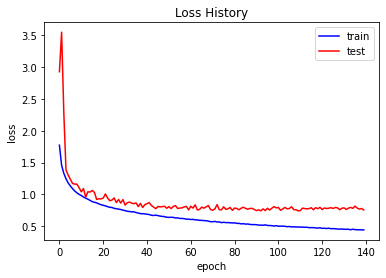

In [ ]:
# Loss history를 그린다
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')
plt.legend()
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1).reshape(-1,1)
acc = (y_test == y_pred).mean()
print('정확도 ={:.4f}'.format(acc))

313/313 [==============================] - 1s 3ms/step
정확도 =0.7610


코드 참고
```
https://gruuuuu.github.io/machine-learning/cifar10-cnn/
```
```
https://github.com/SendurLanter/MobileNet-by-keras-on-cifar10/blob/master/keras_mobilenet_cifar10/model.py
```
```
https://wjunsea.tistory.com/94
```